In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28, 28)  # Reshape for LSTM
x_test = x_test.reshape(-1, 28, 28)

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# SVM

In [7]:
import numpy as np

In [8]:
x_train_svm = x_train.reshape(x_train.shape[0], -1)  # Flatten for SVM
x_test_svm = x_test.reshape(x_test.shape[0], -1)
svm_model = SVC(kernel='rbf')

In [9]:
y_train_svm = np.argmax(y_train, axis=1)
y_test_svm = np.argmax(y_test, axis=1)

Using MPS device
Fold 1/3


Epoch 100/100: 100%|██████████| 1250/1250 [00:10<00:00, 124.94it/s]


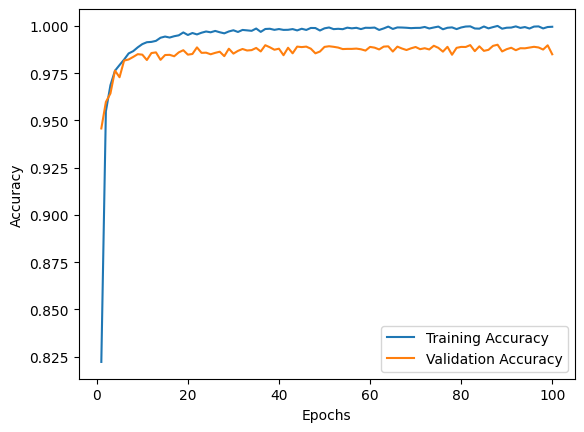

Fold accuracy: 0.985
Fold 2/3


Epoch 100/100: 100%|██████████| 1250/1250 [00:08<00:00, 144.52it/s]


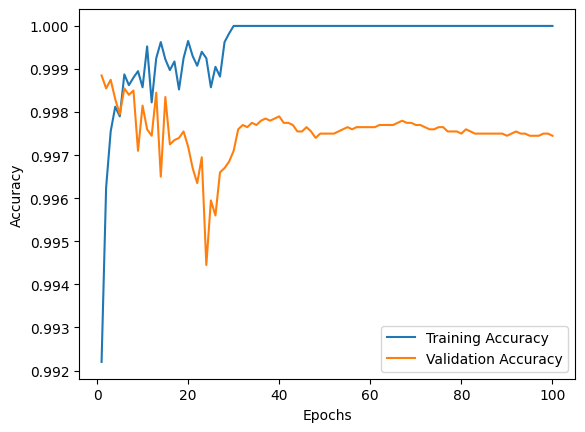

Fold accuracy: 0.99745
Fold 3/3


Epoch 100/100: 100%|██████████| 1250/1250 [00:09<00:00, 138.79it/s]


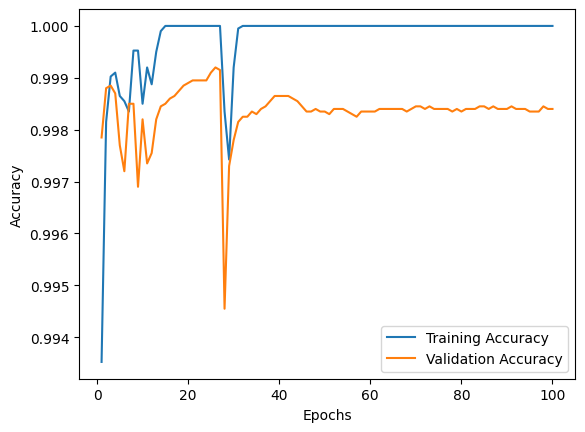

Fold accuracy: 0.9984
LSTM cross-validation scores: [0.985, 0.99745, 0.9984]
Average accuracy: 0.9936166405677795


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.model_selection import KFold
import numpy as np

n_epochs = 100

# Assuming you have your data loaded as x_train and y_train (NumPy arrays)

# Convert data to PyTorch tensors
x_train_tensor = torch.from_numpy(x_train).float()
# Convert one-hot encoded labels to class indices
y_train_indices = torch.from_numpy(np.argmax(y_train, axis=1)).long()

# Check for MPS device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS device not found, using CPU")

# Define your LSTM model in PyTorch
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the model
input_size = 28  # Number of features per timestep
hidden_size = 128  # Number of features in the hidden state
num_layers = 1  # Number of recurrent layers
num_classes = 10  # Number of classes
lstm_model = LSTM(input_size, hidden_size, num_layers, num_classes)

# Move model to the MPS device
lstm_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Perform k-fold cross-validation (e.g., k=3)
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)
cross_lstm_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(x_train_tensor)):
    print(f'Fold {fold + 1}/{k}')

    # Create data loaders for training and validation sets (use y_train_indices)
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)
    train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_indices), batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(TensorDataset(x_train_tensor, y_train_indices), batch_size=32, sampler=val_sampler)

    # Initialize lists to store accuracies
    train_accuracies = []
    val_accuracies = []
    
    # Training loop
    for epoch in range(n_epochs):  # Example: Train for 10 epochs
        lstm_model.train()
        correct_train = 0
        total_train = 0
        for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{n_epochs}'):
            # Move data and target to the MPS device
            data = data.to(device)
            target = target.to(device)  # No need to convert to float anymore
            optimizer.zero_grad()
            output = lstm_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
            _, predicted_train = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted_train == target).sum().item()
    
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
    
        # Validation loop
        lstm_model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data, target in val_loader:
                # Move data and target to the MPS device
                data = data.to(device)
                target = target.to(device)
    
                output = lstm_model(data)
                _, predicted_val = torch.max(output.data, 1)
                total_val += target.size(0)
                correct_val += (predicted_val == target).sum().item()
    
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)
    
    # Plot accuracies
    plt.plot(range(1, n_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, n_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    accuracy = val_accuracies[-1]
    cross_lstm_scores.append(accuracy)
    print(f'Fold accuracy: {accuracy}')

# Print average accuracy across all folds
print(f'LSTM cross-validation scores: {cross_lstm_scores}')
print(f'Average accuracy: {torch.mean(torch.tensor(cross_lstm_scores))}')